# DPX Calibration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cPickle
import hickle
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Support functions
import dpx_func_python as su
import plotToTtoTHL as pttt
import ToTtoEnergy as tte
import THLConversion as thlc

# Reload
reload(su), reload(pttt), reload(tte), reload(thlc)

(<module 'dpx_func_python' from 'dpx_func_python.pyc'>,
 <module 'plotToTtoTHL' from 'plotToTtoTHL.pyc'>,
 <module 'ToTtoEnergy' from 'ToTtoEnergy.pyc'>,
 <module 'THLConversion' from 'THLConversion.pyc'>)

## Input files

In [15]:
ToTDir = '../../dpx_data/Measurements'
# ToTfnList = [ToTDir + '/ToTMeasurement_AmSn4.hck'] 
ToTfnList = ['%s/DPX6/ToTMeasurement_%s.p' % (ToTDir, f) for f in ['AmSn2']] # , 'AmSn2']]
ToTHistFn = 'histMeasurement_AmSn.hck'
SLOT = 2
# ToTtoTHLfn = 'ToTtoTHL/DPX6/ToTtoTHL_5.hck'
ToTtoTHLfn = '../../dpx_data/ToTtoTHL_1.hck' # '../../dpx_data/ToTtoTHL/DPX22/ToTtoTHL_DPX22_2.hck'
# ToTtoTHLfn = 'ToTtoTHL_14.p'

## Convert ToT to THL

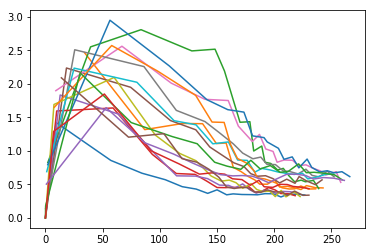

In [15]:
for i in range(16):
    ToT = d[3]['ToT'][i]
    ToTErr = d[3]['ToTErr'][i]
    # print ToT, ToTErr
    plt.plot(ToT, ToTErr)

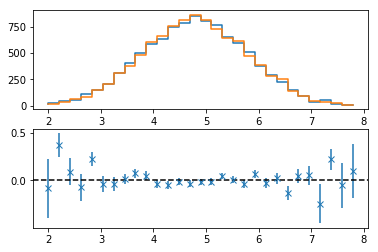

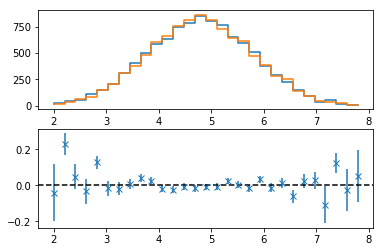

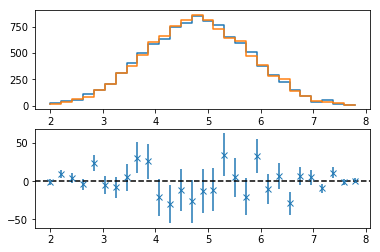

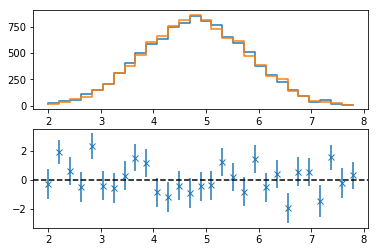

In [5]:
x = np.random.normal(5, 1, 10000)
bins = np.linspace(2, 8, 30)
hist, bins = np.histogram(x, bins=bins)
x = np.random.normal(5, 1, 10000)
hist2, bins2 = np.histogram(x, bins=bins)

hist, hist2 = np.asarray(hist, dtype=float), np.asarray(hist2, dtype=float)

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist - hist2)/hist, yerr=(hist2)/(hist**2)*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist - hist2)/(hist + hist2), yerr=(2*hist2)/((hist + hist)**2)*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], hist - hist2, yerr=np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist-hist2)/np.sqrt(hist), yerr=(hist + hist2)/(2*hist**(1.5))*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

plotToTtoTHL.py:38: RuntimeWarning: invalid value encountered in greater
  THLErr[THLErr > 100] = np.nan
plotToTtoTHL.py:143: RuntimeWarning: divide by zero encountered in divide
  res = np.where(x < b, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
plotToTtoTHL.py:72: RuntimeWarning: invalid value encountered in less_equal
  filtCond = THL_ <= 3000 # abs(THL_ - meanTHL) <= 3 * stdTHL
/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


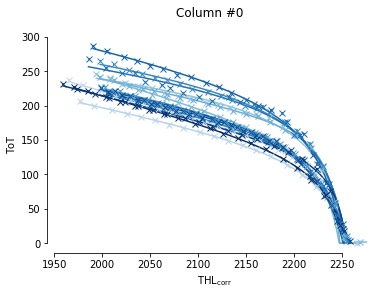

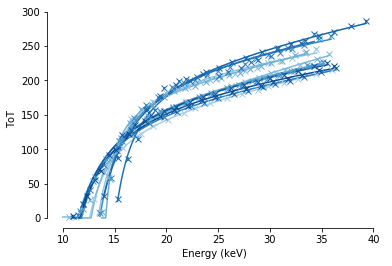

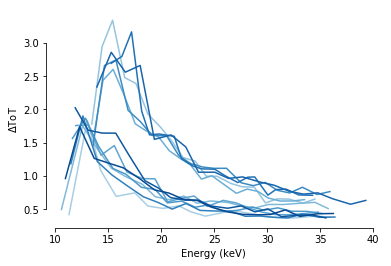

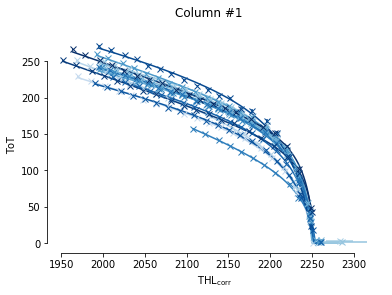

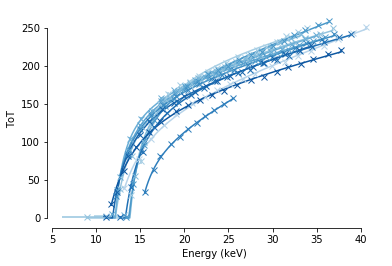

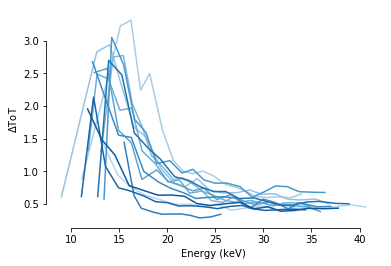

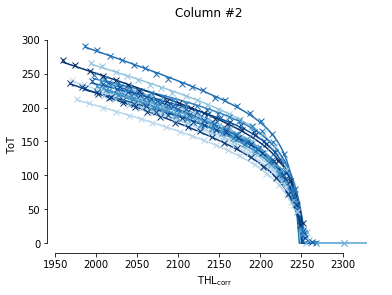

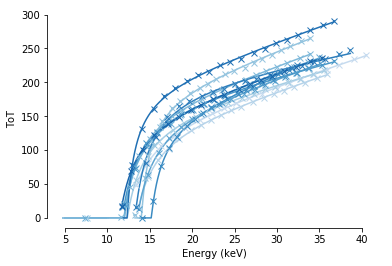

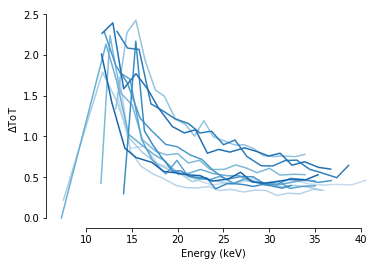

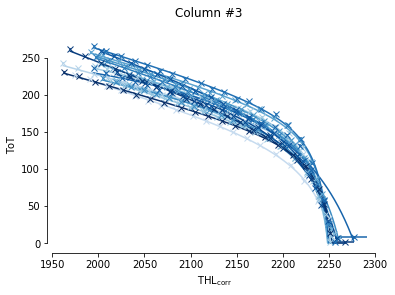

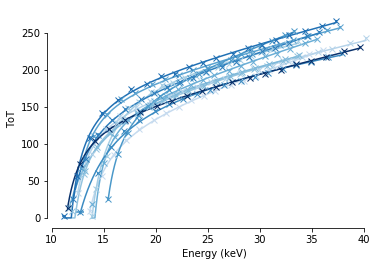

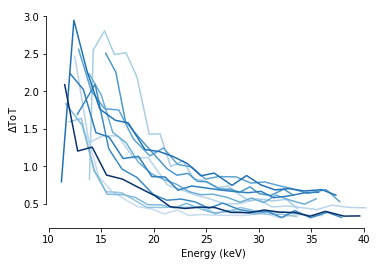

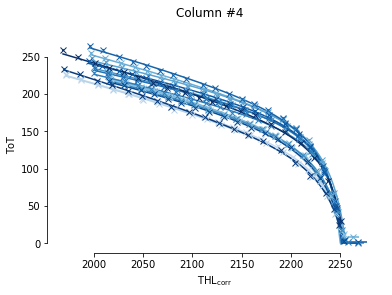

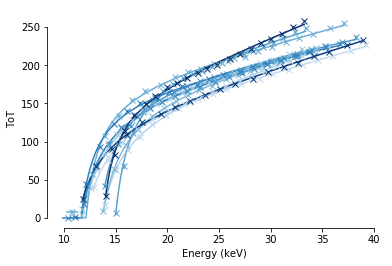

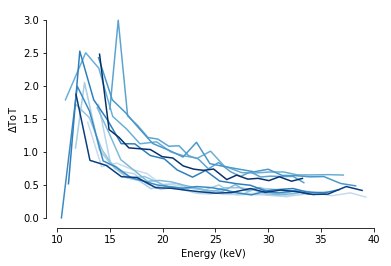

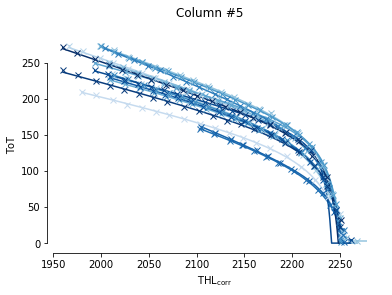

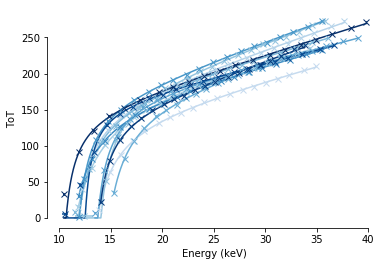

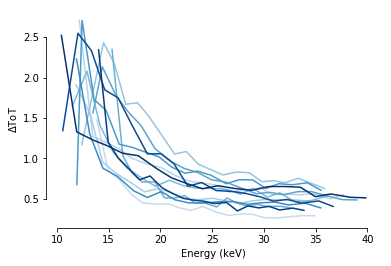

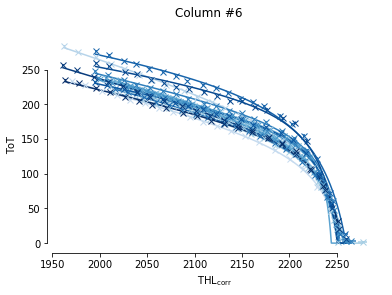

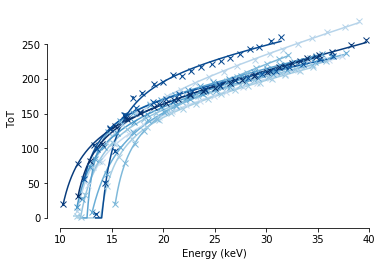

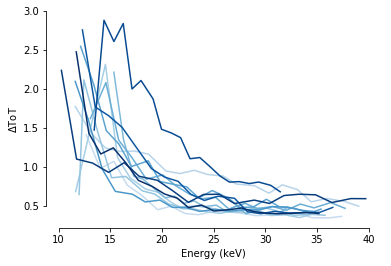

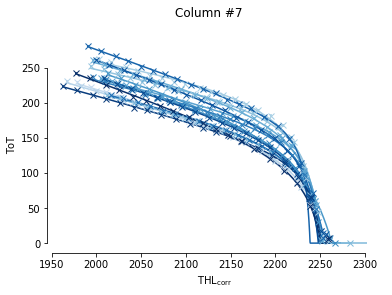

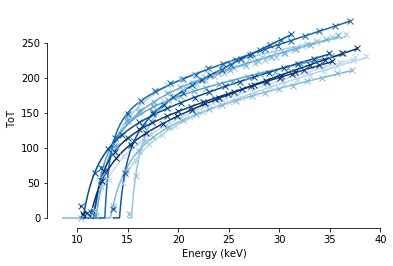

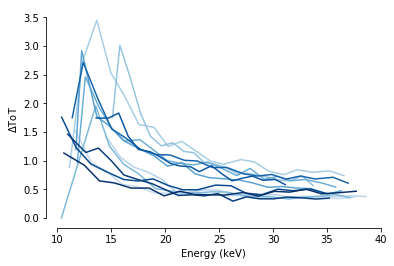

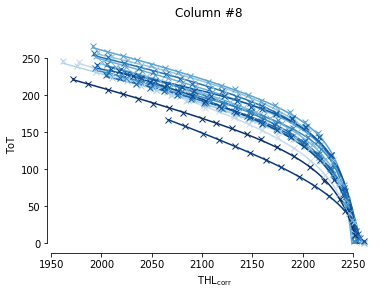

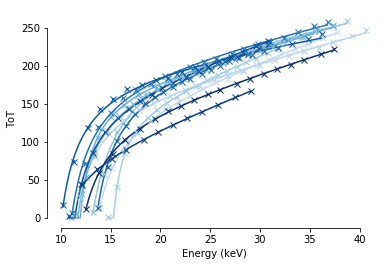

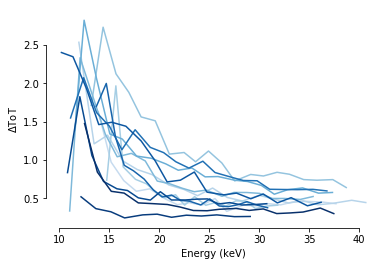

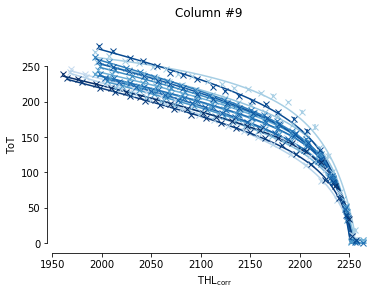

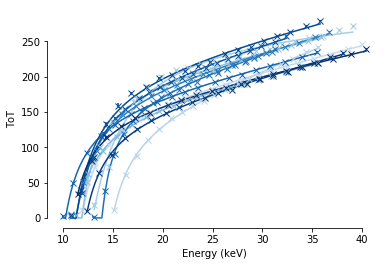

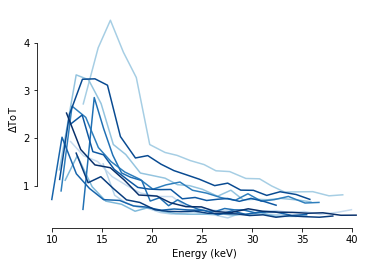

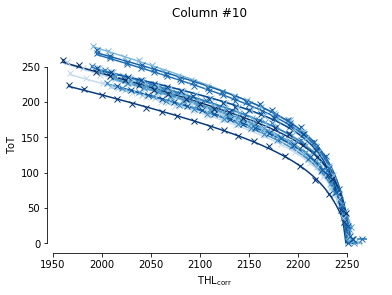

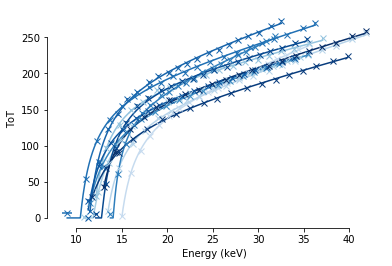

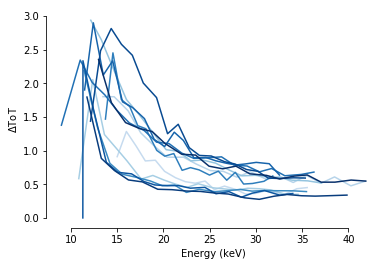

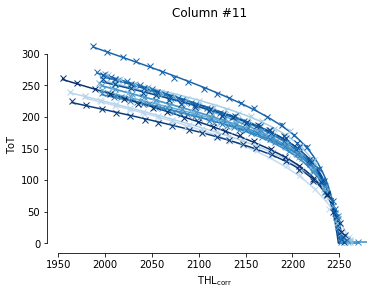

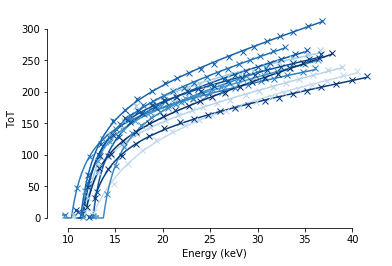

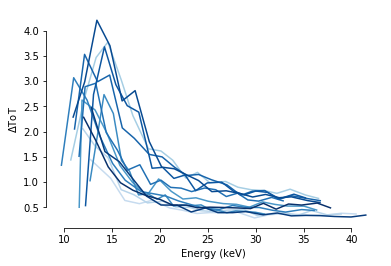

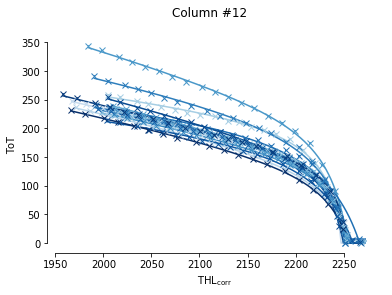

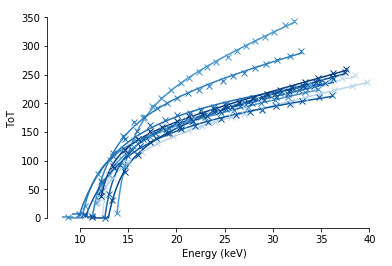

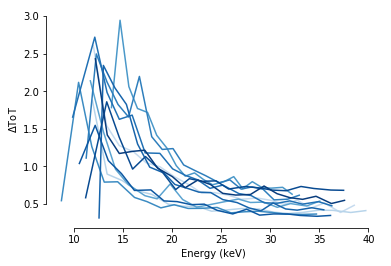

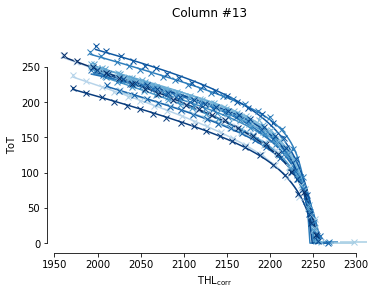

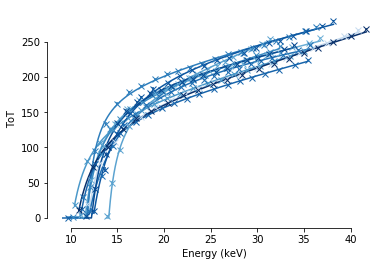

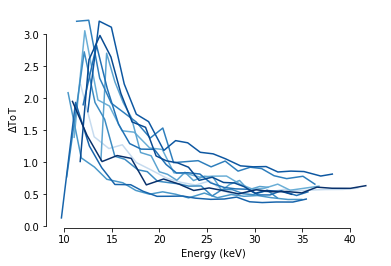

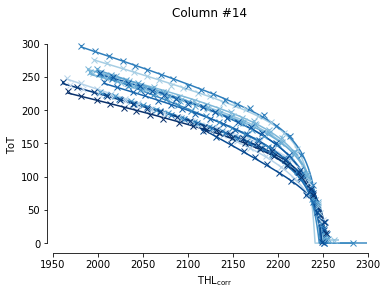

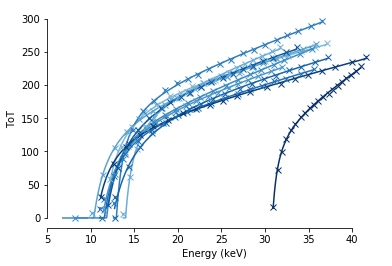

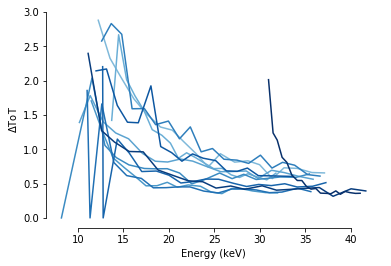

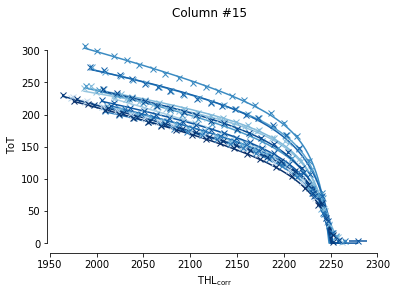

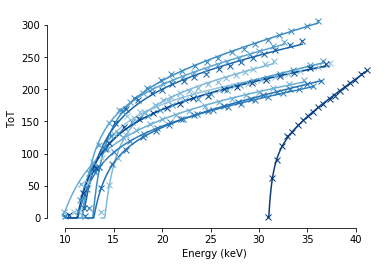

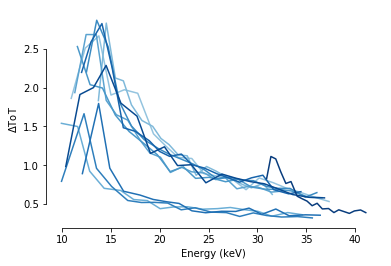

{0: {'a': -0.3727331215457206,
  'b': 2265.295615947925,
  'c': -82.62355476045879,
  't': 23.80667282401473},
 1: {'a': -0.26995057335696415,
  'b': 2283.00913679084,
  'c': -86.00291401357566,
  't': 47.314382604706125},
 2: {'a': -0.30851398562276733,
  'b': 2275.9489726090546,
  'c': -94.3611434045456,
  't': 37.44944157299316},
 3: {'a': -0.15368742406945232,
  'b': 2282.5805466828338,
  'c': -138.07843361093316,
  't': 44.320658179936714},
 4: {'a': -0.37767213433614405,
  'b': 2267.5328390855802,
  'c': -96.03358076934396,
  't': 33.083877652835},
 5: {'a': -0.2680633914030205,
  'b': 2259.281204989346,
  'c': -112.67648885232705,
  't': 17.964035063461814},
 6: {'a': -0.2271159632457611,
  'b': 2289.531854749056,
  'c': -115.0407585603152,
  't': 56.93509202804775},
 7: {'a': -0.2261144447878494,
  'b': 2295.1075390806986,
  'c': -116.63555630899911,
  't': 62.70957550100151},
 8: {'a': -0.19814562259963098,
  'b': 2285.078959598414,
  'c': -144.80716401014487,
  't': 47.984162

In [16]:
reload(pttt)

# Load dictionary
if '.p' in ToTtoTHLfn:
    d = cPickle.load( open(ToTtoTHLfn, 'rb') )
else:
    d = hickle.load(ToTtoTHLfn)
    
# dOut = pttt.plotToTtoTHL(d) # , save='/tmp/')
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')
pttt.plotToTtoTHL(d, convDict=paramsDict)

## Load Spectrum

In [ ]:
dataList = [np.asarray( cPickle.load(open(ToTfn, 'r'))['Slot%d' % 2] ).T for ToTfn in ToTfnList]

In [ ]:
# Combine the data
data = np.hstack(dataList)
len(data), len(dataList[0])

## Convert data to histogram
Idea: Store data in ToT measurements in separate hickle files, containing a certain number of frames each. Afterwards, load them one after another and calculate the histogram for each file. Later, combine these histograms to get the data for the whole dataset. Therefore, the memory requirement is reduced drastically.

In [2]:
def dataToHist(data):
    histDict = {'bins': [], 'hist': []}
    for d in data:
        d = np.asarray(d)
        d = d[d > 0]
        try:
            hist, bins = np.histogram(d, bins=(max(d) - min(d)))
        except:
            hist, bins = None, None
            pass
        histDict['bins'].append(bins), histDict['hist'].append(hist)
        
    return histDict
    
# histDict = dataToHist(data)
histDict = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_complete.hck')
# hickle.dump(histDict, open(ToTDir + '/ToTMeasurementHist_AmSn4.hck', 'w'))

## Convert multiple files to histogram

In [62]:
def dirToHist(directory, slot=1):
    cnt = len(os.listdir(directory))
    startTime = time.time()
    binsTot, histTot = [np.arange(4097)]*256, np.zeros((256, 4096))
    for c, fn in enumerate(os.listdir(directory)[:3]):
        print c
        # if c > cnt:
        #    break
            
        if fn.endswith('.hck'):
            data = hickle.load(directory + '/' + fn)
        elif fn.endswith('.p'):
            data = cPickle.load(open(directory + '/' + fn), 'rb')
        else:
            continue
                
        for i in range(256):
            pixelData = np.asarray(data['Slot%d' % slot])[:,i]
            
            # Filter empty entries
            pixelData = pixelData[pixelData > 0]
            
            hist, bins = np.histogram(pixelData, bins=binsTot[i])
            histTot[i] += hist
            
        print 'Estimated time: %.2f min' % (((time.time() - startTime) / (c + 1) * (cnt - c)) / 60)
            
    # for i in range(256):
    #    bins, hist = binsTot[i], histTot[i]
    #    bins[:-1] = bins[:-1][hist > 0]
    #    hist = hist[hist > 0]
        
    return {'bins': binsTot, 'hist': histTot}
    
testDict = dirToHist('/media/solvalou/58B9EB601FC22312/ToTMeasurement_10')

0
Estimated time: 67.58 min
1
Estimated time: 62.33 min
2
Estimated time: 58.41 min


In [63]:
hickle.dump(testDict, open('../../dpx_data/Measurements/DPX22/Am_uncalib.hck', 'w'))

## Load histograms from file

In [89]:
# histDict = hickle.load(ToTDir + '/DPX6/%s' % ToTHistFn)
histDict2 = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_50.hck')
histDict = hickle.load('../../dpx_data/Measurements/DPX22/Am_wTemp_DPX22.hck')
# histDict = hickle.load('../../dpx_data/Measurements/DPX6/histMeasurement_AmSn.hck')
# histDict = hickle.load('../../dpx_data/ToTMeasurement_7_total.hck')
# histDict = testDict

## Show examples

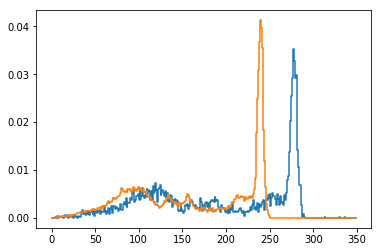

In [90]:
idx = 9
bins, hist = histDict['bins'][idx], histDict['hist'][idx]
hist = hist[bins[:-1] < 350]
bins = bins[bins < 350]

plt.step(bins, hist / float(np.sum(hist)), where='post')

bins, hist = histDict2['bins'][idx], histDict2['hist'][idx]
hist = hist[bins[:-1] < 350]
bins = bins[bins < 350]

plt.step(bins, hist / float(np.sum(hist)), where='post')
plt.show()

## Get conversion parameters for THL to energy

In [23]:
reload(thlc)
paramsDict = thlc.THLConversion(histDict, dOut, plot=False, use_hist=True)

[2226.508456972455, 2155.579667847106, 1926.2617904040744] [2106.909090909096, 1679.1258741258782, 14177.52913752917]
[2222.6446239406137, 2174.3253457183205, 1856.5719158395434] [3231.23776223777, 1654.9766899766942, 13117.442890442922]
[2217.647608899338, 2148.6877873587046, 1932.2502774005968] [2305.680652680658, 1570.8414918414956, 13025.813519813551]
[2223.507548124465, 2170.4843498456153, 1912.9010635307254] [3476.757575757584, 1718.6969696969736, 13289.46153846157]
[2217.590666928848, 2150.8025992328303, 1897.6291362739844] [2897.5058275058345, 1708.939393939398, 14100.230769230802]


/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[2217.1609058324348, 2151.0701524725423, 1903.7977533080143] [2761.6899766899833, 1726.592074592079, 14109.836829836864]
[2222.91694786065, 2176.4778507147357, 1915.0662865866823] [3275.6177156177237, 1524.580419580423, 12380.571095571126]
[2222.3652826865323, 2157.2953954150435, 1925.660411525372] [2449.5291375291436, 1818.1748251748295, 15161.692307692343]
[2249.5600939349647, 2176.046714285363, 1876.7283938602318] [4231.5407925408035, 1494.9743589743625, 11769.21445221448]
[2221.101725479444, 2171.94080054969, 1927.8748390703267] [2784.536130536137, 1391.766899766903, 11526.062937062965]
[2216.165106935252, 2154.5476912250447, 1898.1823656591387] [2944.2843822843897, 1812.2027972028015, 14592.906759906795]
[2212.7371281881497, 2152.97844662929, 1904.7937284930554] [2795.153846153853, 1805.727272727277, 14686.540792540827]
[2214.9908359010897, 2159.2374823484183, 1882.2393443381688] [3247.7179487179565, 1547.6247086247124, 12185.20745920749]
[2213.904947944111, 2150.849962812701, 189

THLConversion.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  mean = 1./np.sum(hist) * np.dot(hist, bins[:-1])
THLConversion.py:68: RuntimeWarning: invalid value encountered in double_scalars
  mean = 1./np.sum(hist) * np.dot(hist, bins[:-1])


[2221.70513076703, 2151.090139816588, 1920.4038129602493] [2563.617715617722, 1730.6410256410297, 13914.361305361337]
[2221.5400596191175, 2152.858454730652, 1928.8357066665335] [2716.9627039627103, 1705.4195804195847, 13903.407925407959]
[2224.1801573366547, 2157.796178677413, 1938.3898050238895] [2287.3846153846207, 1636.5104895104932, 13695.834498834532]
[2224.755686939576, 2156.397321083706, 1914.4326765156484] [2766.4475524475592, 1626.2727272727311, 13293.17948717952]
[2223.260278902724, 2157.3840579250646, 1930.8652053655019] [3208.0675990676064, 1799.9580419580464, 14283.074592074627]
[2225.5698462466235, 2152.965289205603, 1936.5380687815332] [2379.7342657342715, 1632.097902097906, 13448.438228438261]
[2219.5965151564337, 2152.405819542045, 1912.6759494772753] [3438.88811188812, 1754.5151515151558, 13848.862470862503]
[2220.8385800986343, 2158.632269471772, 1903.6463327401198] [3493.729603729612, 1690.6013986014027, 13379.706293706324]
[2218.992253141353, 2167.3769751227437, 1

## ToT to Energy
Use found conversion parameters on data

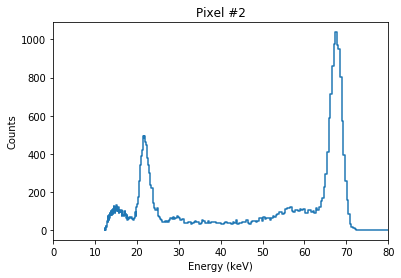

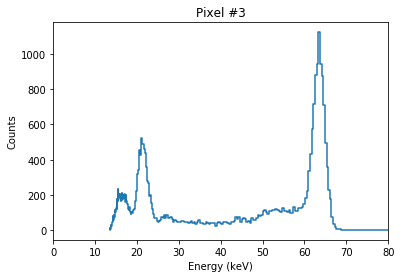

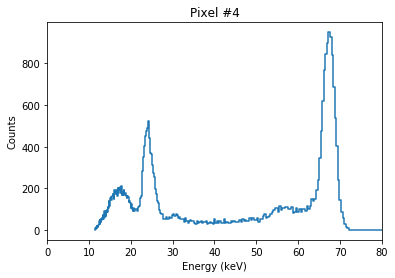

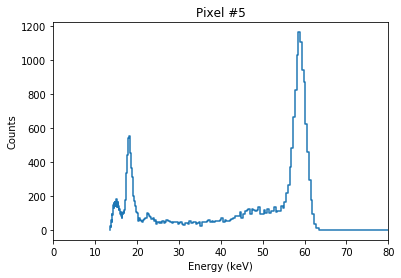

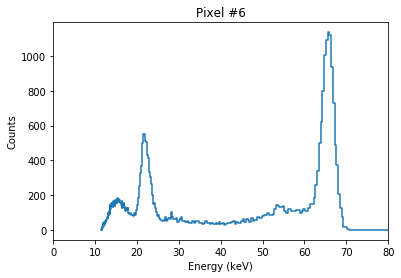

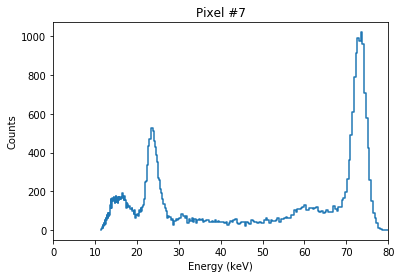

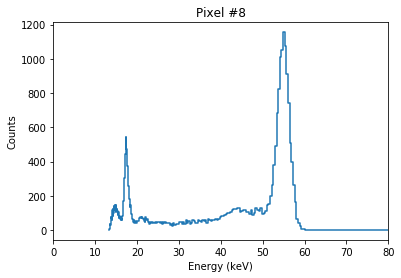

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [44]:
reload(tte)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=True) # , save='/tmp/ToTtoEnergy_AmMo.svg')

## Store to files

In [20]:
hickle.dump(paramsDict, open('energyConversion/paramsDict_DPX22.hck', 'w'))

{'a': -0.2164967954076204, 'c': -93.07962950756063, 'b': 2287.9539225680646, 'h': -0.09356953167888862, 'k': 222.6544402886111, 't': 47.30313834826713}
-0.2164967954076204 2287.9539225680646 -93.07962950756063 47.30313834826713
8.571663251041088
353.24566594731056
66.65312048881157


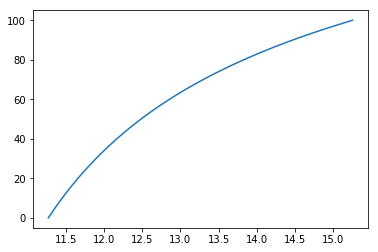

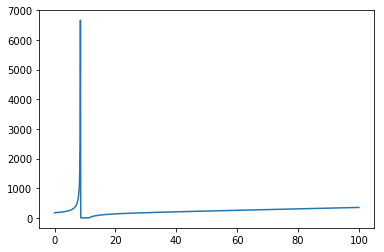

In [19]:
# cPickle.dump(paramsDict, open('testCalibFactors.p', 'wb'))
p = paramsDict[7]
a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
print p
# a /= h
# b = b*h + k
# t *= h
print a, b, c, t

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def EnergyToToTSimple(x, a, b, c, t, h=1, k=0):
    res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
    res[res < 0] = 0
    return res

print(b*h + k)
print(EnergyToToTSimple(100, a, b, c, t, h, k))
print(ToTtoEnergySimple(273.5021034056356, a, b, c, t, h, k))

x = np.linspace(0, 100, 1000)
plt.plot(ToTtoEnergySimple(x, a, b, c, t, h, k), x)
plt.show()
plt.plot(x, EnergyToToTSimple(x, a, b, c, t, h, k))